In [ ]:
'''
Activation Function:
Activation functions are crutial parts of DL models, as
they add the non-linearity to neural network.
In practice, we use ReLu for most of time, and Sigmoid for binary classification.
'''

'\nActivation Function:\nActivation functions are crutial parts of DL models, as\nthey add the non-linearity to neural network.\nIn practice, we use ReLu for most of time, and Sigmoid for binary classification.\n'

In [ ]:
  ## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

<ipython-input-11-a7f785b7f466>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [ ]:
pwd

'/content'

In [ ]:
from torch.cuda import is_available
# Path to save downloaded dataset
DATASET_PATH = "/data"
# Path to folder that save the pretrained models
CHECKPOINT_PATH = "/saved_models/tutorial3"

# Function for setting the seed
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available(): # GPU operation have seperated seed.
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

# Some steps on GPU are stochastic for efficiency
# But we want to make sure all operations are determinstic on GPU (if used) for reproducibility. (means want all can not change)
'''
cuDNN is a GPU-accelerated library that provides highly optimized implementations of many deep learning operations, such as convolution and pooling.

When you set torch.backends.cudnn.deterministic to True, you are telling PyTorch to enforce deterministic behavior in cuDNN.
This means that cuDNN will use deterministic algorithms and configurations for operations,
ensuring that if you run your neural network with the same inputs and parameters multiple times, you should get the exact same results each time.
'''
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching (decide which to use) the device that will be used.
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device:", device)

Using device: cuda:0


In [ ]:
import urllib.request
from urllib.error import HTTPError

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"

# Files to download
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]

# Create checkpoint path if it does not exist yet.
os.makedirs(CHECKPOINT_PATH, exist_ok = True)

# Check if every file is aalready exist, if not, download
for file_name in pretrained_files:
  file_path = os.path.join(CHECKPOINT_PATH, file_name)
  if not os.path.isfile(file_path):
    file_url = base_url + file_name
    print(f"Downloading {file_url}...")
    try:
      urllib.request.urlretrieve(file_url, file_path) # Used for downloading files from url, and save to path.
    except HTTPError as e:
      print("Something went wrong. \
      Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Common Activation Functions

In [ ]:
'''
Implement some common activation functions by ourselves.
Most of the can be found in the torch.nn
However, we will write our own here for better understanding.
'''

# Define basic class
class ActivationFunction(nn.Module):
  def __init__(self):
    super.__init__
    self.name = self.__class__.__name__ # Return the name of class, we use function name as class name
    self.config = {"name": self.name} # Used to store adjustable parameters for some activation functions.

# Sigmoid
class Sigmoid(ActivationFunction):
  def forward(self, x):
    return 1 / (1 + torch.exp(-x))

# Tanh
class Tanh(ActivationFunction):
  def forward(self, x):
    x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
    return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

# ReLU
class ReLU(ActivationFunction):
  def forward(self, x):
    return x * (x > 0).float() # If <= 0, = 0, if > 0 , = x

# LeakyReLU _________________________________
class LeakyReLU(ActivationFunction):

    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

# ELU___________________________________________
class ELU(ActivationFunction):

    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x)-1) # means if x > 0, x, else, torch.exp(x)-1

# Swish
class Swish(ActivationFunction):
  def forward(self, x):
    return x * torch.sigmoid(x)

In [ ]:
-1 * (-1 > 0)

0

In [ ]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

## Visualizing activation function

In [ ]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor.
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"

AttributeError: ignored

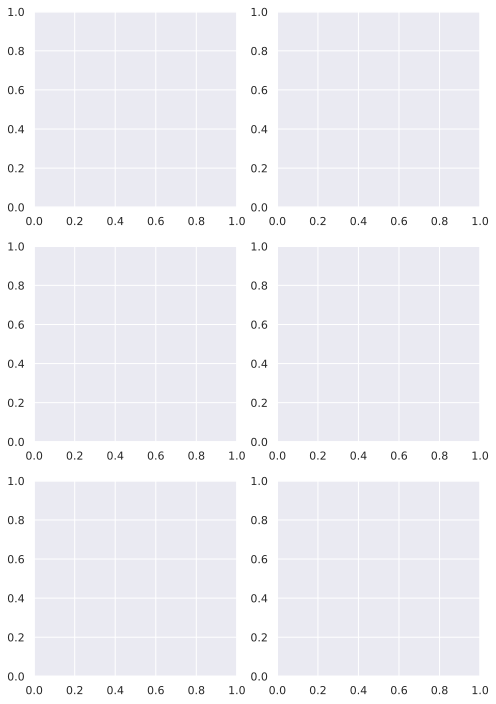

In [ ]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()